Before we start, a couple of things to note here.

1. I used variable thresholding presented in the CWGCNA analysis to find the top 500 features
2. Realized that dagifying the resulting graph is near-to-impossible (kernel keeps crashing, not sure why)
3. Reduced the dimensions down even further to 10 genes
4. Performed the analysis with default settings, you can see results at the end

In [1]:
import sys
sys.path.append("/Users/shamanthk/Documents/iomics/dowhy-preeclampsia")

In [2]:
import numpy as np
import pandas as pd
from EstimateEffect import *

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
betas_df = pd.read_csv('data/betas_500.csv')
pds_df = pd.read_csv('data/pds.csv')

betas_df_t = betas_df.set_index('Unnamed: 0').T.reset_index().rename(columns={'index': 'sampleid'})

merged_df = pd.merge(pds_df, betas_df_t, on='sampleid')

def clean_column_names(col_name):
    if "::" in col_name:
        return col_name.split("::")[0]
    return col_name

merged_df.columns = [clean_column_names(col) for col in merged_df.columns]

merged_df.head()

,Unnamed: 0,sampleid,Group,Gestwk,Babygender,Ethnicity,Dataset,ABO,ACADL,ACOT11,...,ZNF560,ZNF562,ZNF572,ZNF577,ZNF660,ZNF667,ZNF785,ZNF804B,ZSCAN12,ZSCAN16
0,1,GSM788417,Control,8.0,M,White,GSE31781,0.286653,0.100830,0.714489,...,0.216980,0.115556,0.382673,0.141096,0.395113,0.169859,0.554643,0.260140,0.153931,0.155679
1,2,GSM788419,Control,8.0,M,White,GSE31781,0.279650,0.087703,0.713941,...,0.217710,0.078361,0.358216,0.143691,0.394575,0.153465,0.545284,0.221913,0.144950,0.119980
2,3,GSM788420,Control,8.0,M,White,GSE31781,0.268227,0.081340,0.714192,...,0.196714,0.093258,0.367346,0.140717,0.402525,0.159516,0.564620,0.201813,0.142980,0.124261
3,4,GSM788421,Control,9.0,M,White,GSE31781,0.267576,0.080080,0.711066,...,0.184075,0.072457,0.385657,0.141546,0.409713,0.145243,0.549677,0.247063,0.144411,0.129721
4,5,GSM788414,Control,12.0,F,Asian,GSE31781,0.265860,0.078628,0.715149,...,0.208951,0.061186,0.358398,0.140577,0.360815,0.126509,0.499693,0.222571,0.148082,0.121801


In [4]:
df = merged_df.drop(columns=['Unnamed: 0', 'sampleid', 'Gestwk', 'Ethnicity', 'Dataset', 'Babygender'])
df.head()

,Group,ABO,ACADL,ACOT11,ADAMTS14,ADCY4,ADD2,ADORA2B,ADRA1A,ADRA2C,...,ZNF560,ZNF562,ZNF572,ZNF577,ZNF660,ZNF667,ZNF785,ZNF804B,ZSCAN12,ZSCAN16
0,Control,0.286653,0.100830,0.714489,0.216138,0.463232,0.211398,0.556021,0.375335,0.332831,...,0.216980,0.115556,0.382673,0.141096,0.395113,0.169859,0.554643,0.260140,0.153931,0.155679
1,Control,0.279650,0.087703,0.713941,0.186465,0.485031,0.201391,0.620715,0.361520,0.327508,...,0.217710,0.078361,0.358216,0.143691,0.394575,0.153465,0.545284,0.221913,0.144950,0.119980
2,Control,0.268227,0.081340,0.714192,0.195455,0.461802,0.210969,0.545269,0.364272,0.312898,...,0.196714,0.093258,0.367346,0.140717,0.402525,0.159516,0.564620,0.201813,0.142980,0.124261
3,Control,0.267576,0.080080,0.711066,0.188846,0.433606,0.208251,0.617009,0.380944,0.289887,...,0.184075,0.072457,0.385657,0.141546,0.409713,0.145243,0.549677,0.247063,0.144411,0.129721
4,Control,0.265860,0.078628,0.715149,0.164783,0.435845,0.212740,0.615782,0.363593,0.291139,...,0.208951,0.061186,0.358398,0.140577,0.360815,0.126509,0.499693,0.222571,0.148082,0.121801


In [5]:
df['Group'] = df['Group'].map({'Control': 0, 'Preeclampsia': 1})
df.head()

,Group,ABO,ACADL,ACOT11,ADAMTS14,ADCY4,ADD2,ADORA2B,ADRA1A,ADRA2C,...,ZNF560,ZNF562,ZNF572,ZNF577,ZNF660,ZNF667,ZNF785,ZNF804B,ZSCAN12,ZSCAN16
0,0,0.286653,0.100830,0.714489,0.216138,0.463232,0.211398,0.556021,0.375335,0.332831,...,0.216980,0.115556,0.382673,0.141096,0.395113,0.169859,0.554643,0.260140,0.153931,0.155679
1,0,0.279650,0.087703,0.713941,0.186465,0.485031,0.201391,0.620715,0.361520,0.327508,...,0.217710,0.078361,0.358216,0.143691,0.394575,0.153465,0.545284,0.221913,0.144950,0.119980
2,0,0.268227,0.081340,0.714192,0.195455,0.461802,0.210969,0.545269,0.364272,0.312898,...,0.196714,0.093258,0.367346,0.140717,0.402525,0.159516,0.564620,0.201813,0.142980,0.124261
3,0,0.267576,0.080080,0.711066,0.188846,0.433606,0.208251,0.617009,0.380944,0.289887,...,0.184075,0.072457,0.385657,0.141546,0.409713,0.145243,0.549677,0.247063,0.144411,0.129721
4,0,0.265860,0.078628,0.715149,0.164783,0.435845,0.212740,0.615782,0.363593,0.291139,...,0.208951,0.061186,0.358398,0.140577,0.360815,0.126509,0.499693,0.222571,0.148082,0.121801


In [6]:
df = df.drop(columns=df.columns[50:])
df.shape

In [7]:
df.columns

Index(['Group', 'ABO', 'ACADL', 'ACOT11', 'ADAMTS14', 'ADCY4', 'ADD2',
       'ADORA2B', 'ADRA1A', 'ADRA2C', 'ADRB2', 'AEN', 'AIFM2', 'AIRE',
       'AKAP12', 'AKAP3', 'AKR1B1', 'ALK', 'ALKBH3', 'AMDHD1', 'ANKRD30A',
       'ANKRD45', 'ANKRD53', 'ANKRD7', 'ANP32D', 'ANTXR1', 'APCDD1', 'APCDD1L',
       'APOL6', 'ARNT2', 'ARPP-21', 'ARRDC4', 'ART5', 'ATP5G2', 'B3GNT3',
       'B4GALNT2', 'BAK1', 'BCL11B', 'BCL2A1', 'BMP10', 'BNIP3', 'BOLL',
       'C10orf11', 'C11orf92', 'C11orf93', 'C13orf33', 'C14orf162', 'C15orf2',
       'C16orf63', 'C18orf16'],
      dtype='object')

In [8]:
EstimationModel = EstimateEffect(df)

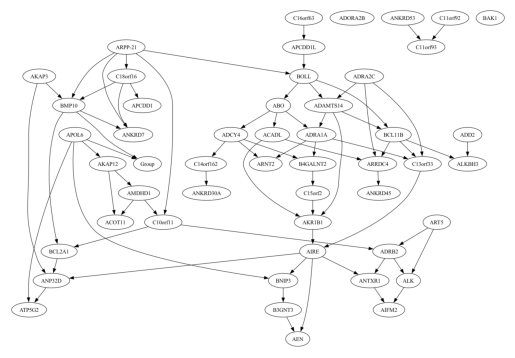

In [9]:
causal_graph = EstimationModel.find_causal_graph(algo='CCDr')

disp_graph_nx(causal_graph)

In [10]:
causal_graph.edges

OutEdgeView([('ABO', 'ACADL'), ('ABO', 'ADCY4'), ('ABO', 'ADRA1A'), ('ACADL', 'AKR1B1'), ('ACADL', 'ARRDC4'), ('ADAMTS14', 'ADRA1A'), ('ADAMTS14', 'AKR1B1'), ('ADAMTS14', 'BCL11B'), ('ADCY4', 'ARNT2'), ('ADCY4', 'B4GALNT2'), ('ADCY4', 'C14orf162'), ('ADD2', 'ALKBH3'), ('ADRA1A', 'ARNT2'), ('ADRA1A', 'B4GALNT2'), ('ADRA1A', 'C13orf33'), ('ADRA2C', 'ARRDC4'), ('ADRA2C', 'C13orf33'), ('ADRA2C', 'ADAMTS14'), ('ADRB2', 'ALK'), ('ADRB2', 'ANTXR1'), ('AIRE', 'AEN'), ('AIRE', 'ANP32D'), ('AIRE', 'ANTXR1'), ('AIRE', 'BNIP3'), ('AKAP12', 'ACOT11'), ('AKAP12', 'AMDHD1'), ('AKAP3', 'BMP10'), ('AKAP3', 'ANP32D'), ('AKR1B1', 'AIRE'), ('ALK', 'AIFM2'), ('AMDHD1', 'ACOT11'), ('AMDHD1', 'C10orf11'), ('ANKRD53', 'C11orf93'), ('ANP32D', 'ATP5G2'), ('ANTXR1', 'AIFM2'), ('APCDD1L', 'BOLL'), ('APOL6', 'AKAP12'), ('APOL6', 'ATP5G2'), ('APOL6', 'BNIP3'), ('APOL6', 'Group'), ('ARPP-21', 'ANKRD7'), ('ARPP-21', 'BOLL'), ('ARPP-21', 'C10orf11'), ('ARPP-21', 'C18orf16'), ('ARPP-21', 'BMP10'), ('ARRDC4', 'ANKRD45')

In [11]:
nx.is_directed(causal_graph)

True

In [12]:
nx.is_directed_acyclic_graph(causal_graph)

True

Test permutations of given graph: 100%|██████████| 100/100 [17:34<00:00, 10.55s/it]


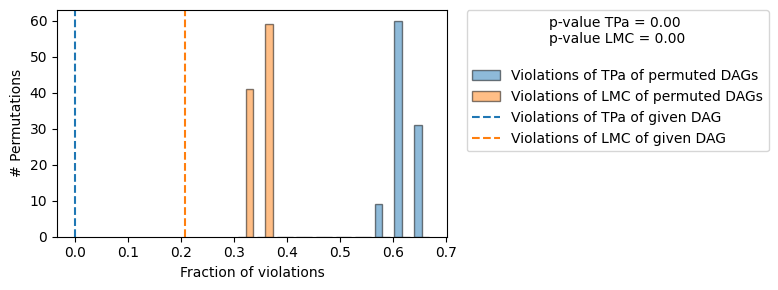

In [13]:
EstimationModel.refute_cgm(show_plt=True, n_perm=100)

In [14]:
EstimationModel.create_model(treatment='ARPP-21', outcome='Group')

In [15]:
print(EstimationModel.identify_effect())

KeyboardInterrupt: 

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
EstimationModel.estimate_effect()

Note that it is ok for your treatment to be a continuous variable, DoWhy automatically discretizes at the backend.


In [18]:
EstimationModel.refute_estimate(placebo_type="permute")

In [19]:
info = EstimationModel.get_all_information()

In [20]:
print(info['graph_refutation_res'])

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 100 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 1/50 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [21]:
print(info['estimand_expression'])

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d              
─────────(E[Group])
d[ADRA1A]          
Estimand assumption 1, Unconfoundedness: If U→{ADRA1A} and U→Group then P(Group|ADRA1A,,U) = P(Group|ADRA1A,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡                  d                               ∂                         
E⎢──────────────────────────────────────(Group)⋅─────────([ADRA2C  ACADL  ADAM
 ⎣d[ADRA2C  ACADL  ADAMTS₁₄  ABO  ADCY₄]        ∂[ADRA1A]                     

                  ⎤
TS₁₄  ABO  ADCY₄])⎥
                  ⎦
Estimand assumption 1, Full-mediation: ADRA2C,ACADL,ADAMTS14,ABO,ADCY4 intercepts (blocks) all directed paths from ADRA1A to G,r,o,u,p.
Estimand assumption 2, First-stage-unconfoundedness: If U→{ADRA1A} and U→{ADRA2C,ACADL,ADAMTS14,ABO,ADCY4} then P(ADRA2C,ACADL,ADAMTS14,ABO,ADCY4|ADRA1A,U) = P(

In [24]:
print(info['effect_estimate'].interpret())

Increasing the treatment variable(s) [ADRA1A] from 0 to 1 causes an increase of 0.9848741244548878 in the expected value of the outcome [['Group']], over the data distribution/population represented by the dataset.
None


In [23]:
print(info['estimate_refutation_res'])

Refute: Use a Placebo Treatment
Estimated effect:0.9848741244548878
New effect:-0.032678911848069314
p value:0.96

